# Table of contents
## Business Problem
### Data Loading and Preparation
### Data Exploration
### Data Analysis
### Summary


## Overview
- What are the data form
- what do the data describe
- Goals/Needs of the business
- summary

### Business Problem
- Recommend Movie for Facebook

#### List of questions to answer
1. What are the top 20 most watched genres(single genre)
2. Which genre has been watched the most in the recent years?
3. What particular genre has more gross income?
4. What is the recent trend in movie
5. What is the trend in production cost vs return?

Criteria:
- Budget limit :  >$50 mil
- Release time of year

## Data Loading and Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# Read csv files
df_imdb_name = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.name.basics.csv.gz')
df_imdb_aka = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.akas.csv.gz')
df_imdb_basic = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.basics.csv.gz')
df_imdb_crew = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.crew.csv.gz')
df_imdb_principal = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.principals.csv.gz')
df_imdb_ratings = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.ratings.csv.gz')

### Explore IMDB Datasets

In [3]:
# display(df_imdb_name.head(3))
# display(df_imdb_aka.head(3))
# display(df_imdb_basic.head(3))
# display(df_imdb_crew.head(3))
# display(df_imdb_principal.head(3))
# display(df_imdb_ratings.head(3))

In [4]:
# We will only use two IMDB datasets for our analysis

# Merge dataframes
df_imdb_merge = pd.merge(df_imdb_basic, df_imdb_ratings, on='tconst')

df_imdb_merge['title'] = df_imdb_merge['original_title']  # rename title
df_imdb_merge['year'] = df_imdb_merge['start_year']       # rename year
df_imdb_merge['genre'] = df_imdb_merge['genres']          # rename genre

df_imdb_merge.drop(columns = ['tconst', 'primary_title', 'original_title', 'start_year', 'genres'], inplace=True)

# Check to see how many rows lost in the process
print('No. of observations for imdb_basic:', df_imdb_basic.shape)
print('No. of observations for imdb_ratings:', df_imdb_ratings.shape)
print('No. of observations for imdb_crew:', df_imdb_crew.shape)
print('No. of observations for after merging imdb_basic and ratings:', df_imdb_merge.shape)

# df_imdb_merge = pd.merge(df_imdb_merge, df_imdb_crew, on='tconst')
# print('No. of observations for after mering imdb_basic, ratings and crew merged:', df_imdb_merge.shape)

No. of observations for imdb_basic: (146144, 6)
No. of observations for imdb_ratings: (73856, 3)
No. of observations for imdb_crew: (146144, 3)
No. of observations for after merging imdb_basic and ratings: (73856, 6)


In [5]:
# Lets replace the missing values. Although the  
# df_imdb_merge.fillna(value=0, inplace=True)
df_imdb_merge.head()

,runtime_minutes,averagerating,numvotes,title,year,genre
0,175.0,7.0,77,Sunghursh,2013,"Action,Crime,Drama"
1,114.0,7.2,43,Ashad Ka Ek Din,2019,"Biography,Drama"
2,122.0,6.9,4517,The Other Side of the Wind,2018,Drama
3,NaN,6.1,13,Sabse Bada Sukh,2018,"Comedy,Drama"
4,80.0,6.5,119,La Telenovela Errante,2017,"Comedy,Drama,Fantasy"


In [6]:
df_imdb_merge['genre'] = df_imdb_merge['genre'].str.strip()

In [7]:
# Remove some non-movie category:
# AFI and BFI's definitions call any film longer than 40 minutes a feature.
# We will also get rid of movies that have rating below 5

df_imdb_merge_filter = df_imdb_merge[(df_imdb_merge['runtime_minutes'] >= 40)]
                                     #(df_imdb_merge['averagerating'] > 5)]



# Remove some non-movie category
df_imdb_merge_filter = df_imdb_merge[(df_imdb_merge['genre'] !='Documentary') & 
                                     (df_imdb_merge['genre'] !='Biography') & 
                                     (df_imdb_merge['genre'] !='History') &
                                     (df_imdb_merge['genre'] !='Music') &
                                     (df_imdb_merge['genre'] !='Reality-TV') & 
                                     (df_imdb_merge['genre'] != 'Sport') &
                                     (df_imdb_merge['genre'] != 'Short') &
                                     (df_imdb_merge['genre'] != 'News')
                                    ]
df_imdb_merge_filter.head()

,runtime_minutes,averagerating,numvotes,title,year,genre
0,175.0,7.0,77,Sunghursh,2013,"Action,Crime,Drama"
1,114.0,7.2,43,Ashad Ka Ek Din,2019,"Biography,Drama"
2,122.0,6.9,4517,The Other Side of the Wind,2018,Drama
3,NaN,6.1,13,Sabse Bada Sukh,2018,"Comedy,Drama"
4,80.0,6.5,119,La Telenovela Errante,2017,"Comedy,Drama,Fantasy"


In [57]:
def make_genre_columns(df, genre_col):
    '''
    Split the individual genre type and put them into a separate column
    
    '''    
    # Get list of genres 
    list_of_all_genres = ','.join(str(x) for x in genre_col.unique())    
    unique_genres = {x for x in list_of_all_genres.split(',')}   # set comprehension
    print(unique_genres)
    
    # Get columns for each genre; values 0 or 1 if in that genre
    # make a copy of the dataframe
    df_copy = df.copy(deep=True)
    
    for genre in unique_genres:
        df_copy[genre] = df_copy.apply(lambda x: int(genre in str(x.genre)), axis=1) 
        
       
    return df_copy 

In [9]:
df_imdb_genres = make_genre_columns(df_imdb_merge, df_imdb_merge['genre'])

In [10]:
genres_to_discard = ['Music', 'Sport', 'History', 'Game-Show', 'Musical', 'News', 'Adult',
                     'Short', 'Biography', 'nan', 'Documentary', 'Reality-TV']
df_imdb_genres.drop(columns= genres_to_discard, inplace=True)

In [11]:
df_imdb_genres.columns

Index(['runtime_minutes', 'averagerating', 'numvotes', 'title', 'year',
       'genre', 'Adventure', 'War', 'Drama', 'Crime', 'Fantasy', 'Comedy',
       'Action', 'Animation', 'Horror', 'Sci-Fi', 'Mystery', 'Romance',
       'Thriller', 'Western', 'Family'],
      dtype='object')

In [12]:
# let calculate the count of total movies by genre each year
df_imdb_genres_count = df_imdb_genres.groupby('year').sum()
df_imdb_genres_count.drop(columns=['runtime_minutes', 'averagerating', 'numvotes'], inplace=True)
df_imdb_genres_count_T = df_imdb_genres_count.transpose()

In [13]:
df_imdb_genres_count_T = df_imdb_genres_count.transpose()


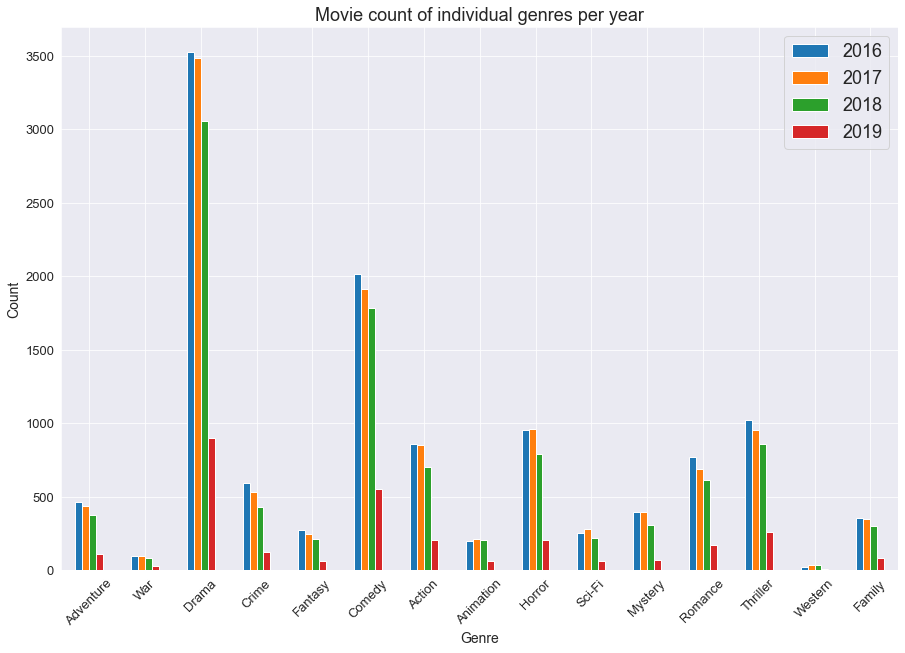

In [14]:
df_imdb_genres_count_T.iloc[:, 6:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Movie count of individual genres per year", fontsize = 18)
plt.ylabel("Count", fontsize = 14)
plt.xlabel("Genre", fontsize = 14)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});

In [15]:
df_imdb_genres.head(3)

,runtime_minutes,averagerating,numvotes,title,year,genre,Adventure,War,Drama,Crime,...,Comedy,Action,Animation,Horror,Sci-Fi,Mystery,Romance,Thriller,Western,Family
0,175.0,7.0,77,Sunghursh,2013,"Action,Crime,Drama",0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
1,114.0,7.2,43,Ashad Ka Ek Din,2019,"Biography,Drama",0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,122.0,6.9,4517,The Other Side of the Wind,2018,Drama,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
genre_list = ['Drama', 'Animation', 'Thriller', 'Action', 'Western', 'Mystery', 'Horror',
                   'Crime', 'Comedy', 'Sci-Fi', 'War', 'Fantasy', 'Adventure', 'Romance', 'Family']

In [17]:
def fill_genre(df, genre_list, col_feature, columns_to_drop ):
    '''
    Fill the genre columns with values from desired feature or column
    col = desired feature
    '''
    for genre in list(genre_list):
        df[genre] = df[genre] * col_feature
    return df.drop(columns=columns_to_drop)

In [18]:
columns_to_drop = ['runtime_minutes', 'averagerating', 'numvotes', 'title', 'genre']
df_imdb_fill_ratings = fill_genre(df_imdb_genres, genre_list, df_imdb_genres['averagerating'], columns_to_drop)
df_imdb_fill_numvote  = fill_genre(df_imdb_genres, genre_list, df_imdb_genres['numvotes'], columns_to_drop)
df_imdb_fill_runtime  = fill_genre(df_imdb_genres, genre_list, df_imdb_genres['runtime_minutes'], columns_to_drop)

In [19]:
# df_imdb_fill_ratings_average.head()

In [20]:
# let calculate some statistics and group by year 
df_imdb_fill_ratings_average = df_imdb_fill_ratings.groupby('year').mean()
df_imdb_fill_ratings_average_T = df_imdb_fill_ratings_average.transpose()

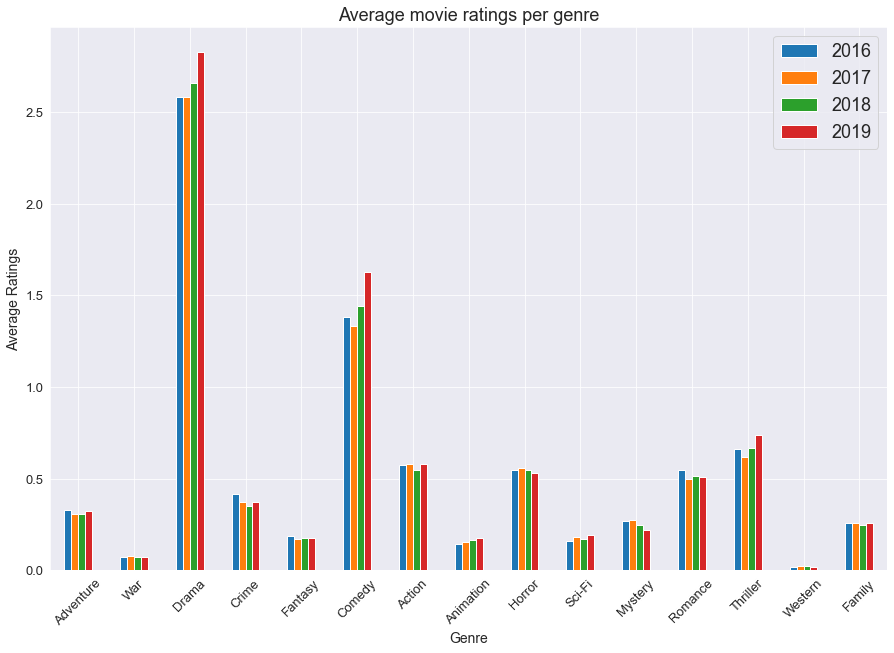

In [21]:
df_imdb_fill_ratings_average_T.iloc[:, 6:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Average movie ratings per genre", fontsize = 18)
plt.ylabel("Average Ratings", fontsize = 14)
plt.xlabel("Genre", fontsize = 14)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});

In [22]:
# let calculate some statistics and group by year 
df_imdb_fill_numvote_average = df_imdb_fill_numvote.groupby('year').mean()
df_imdb_fill_numvote_average_T = df_imdb_fill_numvote_average.transpose()

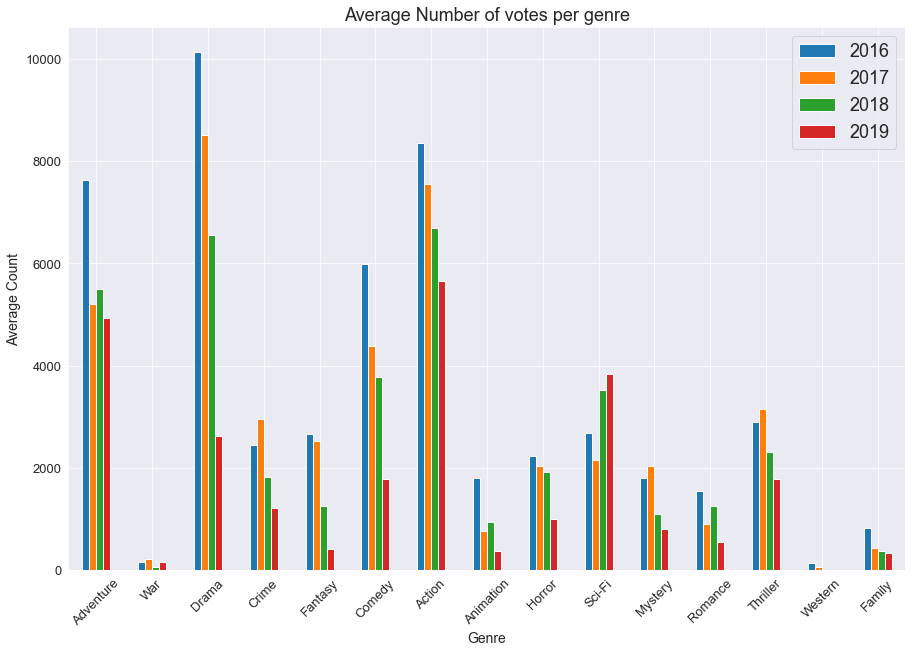

In [23]:
df_imdb_fill_numvote_average_T.iloc[:, 6:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Average Number of votes per genre", fontsize = 18)
plt.ylabel("Average Count", fontsize = 14)
plt.xlabel("Genre", fontsize = 14)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});

In [24]:
# let calculate some statistics and group by year 
df_imdb_fill_runtime_average = df_imdb_fill_runtime.groupby('year').mean()
df_imdb_fill_runtime_average_T = df_imdb_fill_runtime_average.transpose()

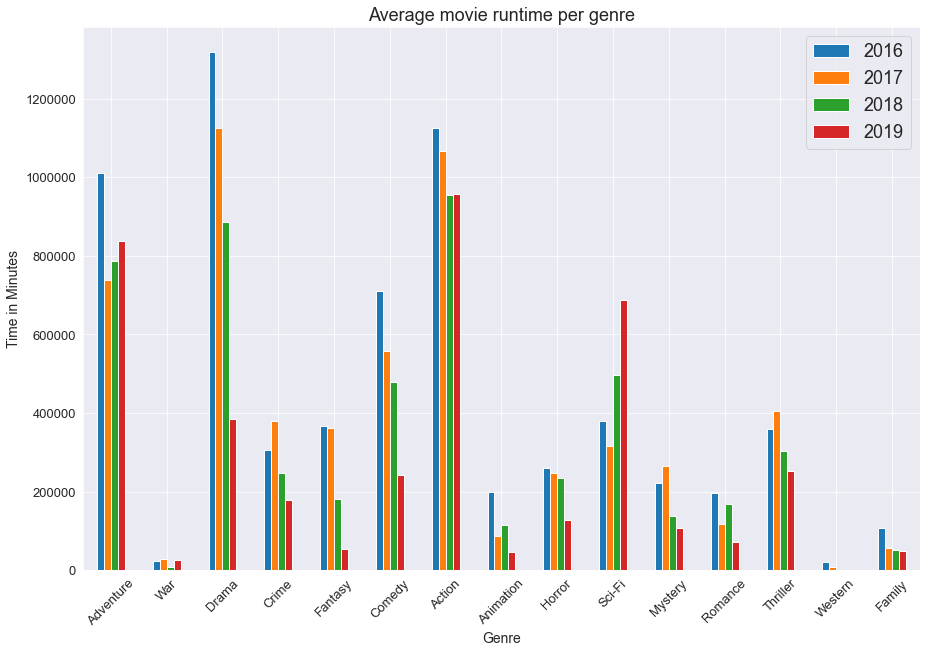

In [25]:
df_imdb_fill_runtime_average_T.iloc[:, 6:].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Average movie runtime per genre", fontsize = 18)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylabel("Time in Minutes", fontsize = 14)
plt.xlabel("Genre", fontsize = 14)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});

### Load TMDB movies dataset

In [26]:
df_tmdb_raw = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/tmdb.movies.csv.gz')

In [27]:
# display(df_tmdb.info())
# display(df_tmdb.head())

We can see some genre id represented by some numbers. We can actually find the exact genre if we go to the tmdb genre website [here](https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee)

Below is a dictionary of 'Movie' genres pertaining the number represantative

In [28]:
temp = {'Action': 28,
             'Adventure': 12,
             'Animation': 16,
             'Comedy': 35,
             'Crime': 80,
             'Documentary': 99,
             'Drama': 18,
             'Family': 10751,
             'Fantasy': 14,
             'History':36,
             'Horror': 27,
             'Music': 10402,
             'Mystery': 9648,
             'Romance': 10749,
             'Science Fiction': 878,
             'TV Movie': 10770,
             'Thriller': 53,
             'War': 1075,
             'Western': 37}

# Switch key-value pairs
tmdb_genre = {}
for k,v in temp.items():
    tmdb_genre[v] = k

In [29]:
def str_replace(input_str, key_dict=tmdb_genre, unknown_genre_str="UNK"):
    '''
    Replace genre id in integer format by text.
    Strip and split non-alphabetic characters and unpack into a list of genres.
    
    '''
    final_str = ""
    # Remove the first and last characters []
    final_str = input_str[1:-1]
    # Split the string to get list of numbers
    final_str = final_str.strip().split(',')
    # Assuming all strings are integers
    #TODO: Find when int() cast doesn't work
    try:
        final_str = [int(x) for x in final_str]
        # Replace numbers with words
        final_str = [key_dict.get(k,unknown_genre_str) for k in final_str]
        # Make one big string to return
    except:
        final_str = ""
    return ','.join(final_str)

In [30]:
df_tmdb = df_tmdb_raw.copy(deep=True)
df_tmdb['genre'] = df_tmdb['genre_ids'].apply(str_replace)


# we will extract 'year' and save it in a column.
df_tmdb['year'] = pd.DatetimeIndex(df_tmdb['release_date']).year

df_tmdb.drop(columns= ['Unnamed: 0','genre_ids', 'id', 'original_language', 'original_title'], inplace=True)
df_tmdb.head()

,popularity,release_date,title,vote_average,vote_count,genre,year
0,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Adventure,Fantasy,Family",2010
1,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"Fantasy,Adventure,Animation,Family",2010
2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Adventure,Action,Science Fiction",2010
3,28.005,1995-11-22,Toy Story,7.9,10174,"Animation,Comedy,Family",1995
4,27.920,2010-07-16,Inception,8.3,22186,"Action,Science Fiction,Adventure",2010


#### Q1. Which movie has the highest/lowest average votes/vote count?

In [31]:
def find_minmax(df,x):
    '''
    Return indices of a minimum or maximum of given features
    Return associated dataframes
    " This function was taken from a kaggle project"
    '''
    # Given the attribute, find min and max
    index_min = df[x].idxmin()
    index_max = df[x].idxmax()
    
    max = pd.DataFrame(df.loc[index_max, :])
    min = pd.DataFrame(df.loc[index_min, :])
    
    print("Movie with highest " + x + ":", df[x][index_max])
    print("Movie with lowest " + x + ":", df[x][index_min])
    
    return pd.concat([min, max], axis=1)    

In [32]:
find_minmax(df_tmdb, 'vote_average')

Movie with highest vote_average: 10.0
Movie with lowest vote_average: 0.0


,2467,770
popularity,0.6,2.288
release_date,2010-01-01,2010-01-01
title,Edie: Girl on Fire,Full Love
vote_average,0,10
vote_count,1,1
genre,,"Action,Crime,Drama,Thriller"
year,2010,2010


In [33]:
find_minmax(df_tmdb, 'vote_count')

Movie with highest vote_count: 22186
Movie with lowest vote_count: 1


,770,4
popularity,2.288,27.92
release_date,2010-01-01,2010-07-16
title,Full Love,Inception
vote_average,10,8.3
vote_count,1,22186
genre,"Action,Crime,Drama,Thriller","Action,Science Fiction,Adventure"
year,2010,2010


#### Most popular movie

In [34]:
data = pd.DataFrame(df_tmdb.groupby('title')['popularity'].mean().sort_values(ascending=False).head(10))
data.reset_index(inplace=True)

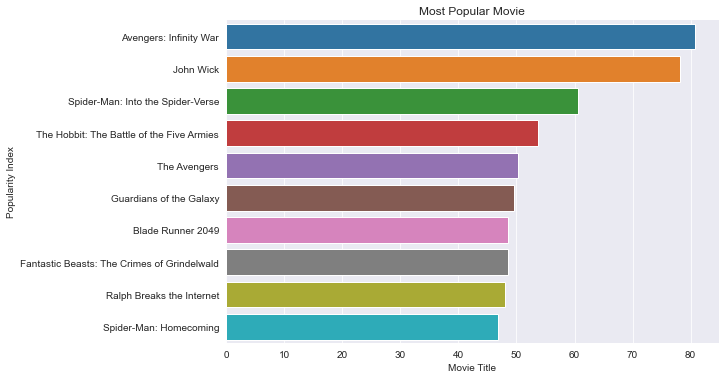

In [35]:
# df_tmdb.groupby('title')['popularity'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='purple', figsize=(12,8))

data = pd.DataFrame(df_tmdb.groupby('title')['popularity'].mean().sort_values(ascending=False).head(10))
data.reset_index(inplace=True)
ax = sns.catplot(data = data, y='title', x='popularity', orient='h', kind='bar', aspect=2)
plt.xlabel('Movie Title')
plt.ylabel('Popularity Index')
plt.xticks(rotation= None)
plt.title('Most Popular Movie');

#### Add genre columns

In [49]:
df_tmdb_genre = make_genre_columns(df_tmdb, df_tmdb['genre'])

{'Adventure', 'Science Fiction', '', 'History', 'Crime', 'Fantasy', 'Comedy', 'Action', 'Documentary', 'Animation', 'Music', 'UNK', 'TV Movie', 'Horror', 'Mystery', 'Romance', 'Family', 'Thriller', 'Western', 'Drama'}


In [40]:
df_tmdb_genre.columns

Index(['popularity', 'release_date', 'title', 'vote_average', 'vote_count',
       'genre', 'year', 'Adventure', 'Science Fiction', '', 'History', 'Crime',
       'Fantasy', 'Comedy', 'Action', 'Documentary', 'Animation', 'Music',
       'UNK', 'TV Movie', 'Horror', 'Mystery', 'Romance', 'Family', 'Thriller',
       'Western', 'Drama'],
      dtype='object')

In [50]:
# War genre is not detected, so we will remove that
tmdb_genre_list = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 
                   'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 
                   'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'Western']

#### Fill genre columns

In [51]:
temp_columns_to_drop = ['popularity', 'release_date', 'title', 'vote_average', 'vote_count', 'genre', '', 'UNK']
df_tmdb_popularity = fill_genre(df_tmdb_genre, tmdb_genre_list, df_tmdb_genre['popularity'], temp_columns_to_drop)
df_tmdb_avgvote = fill_genre(df_tmdb_genre, tmdb_genre_list, df_tmdb_genre['vote_average'], temp_columns_to_drop)
df_tmdb_votecount = fill_genre(df_tmdb_genre, tmdb_genre_list, df_tmdb_genre['vote_count'], temp_columns_to_drop)

In [52]:
df_tmdb_popularity_avg = df_tmdb_popularity.groupby('year').mean()
df_tmdb_popularity_avg_T = df_tmdb_popularity_avg.transpose()

df_tmdb_popularity_std = df_tmdb_popularity.groupby('year').std()
df_tmdb_popularity_std_T = df_tmdb_popularity_std.transpose()

In [53]:
df_tmdb_vote_avg = df_tmdb_avgvote.groupby('year').mean()
df_tmdb_vote_avg_T = df_tmdb_avgvote.transpose()

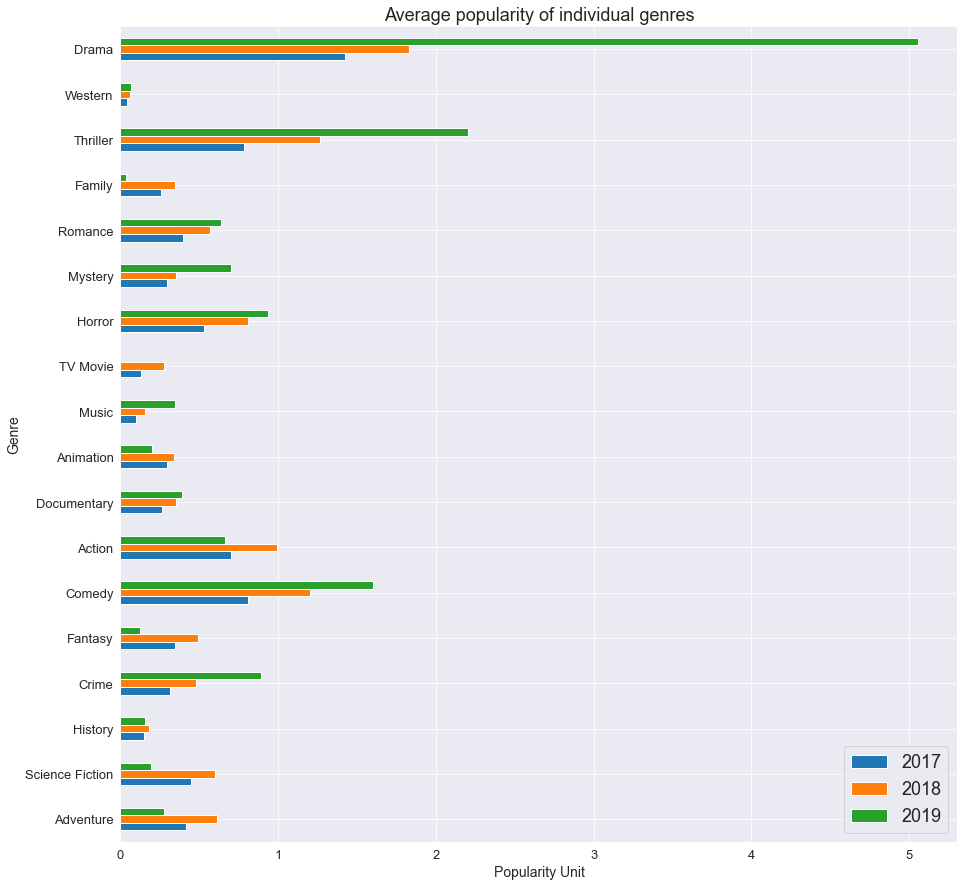

In [54]:
# Plot tmdb popularity
df_tmdb_popularity_avg_T.iloc[:, 62:65].plot(kind='barh',figsize = (15,15),fontsize=13)
plt.title("Average popularity of individual genres", fontsize = 18)
plt.xlabel("Popularity Unit", fontsize = 14)
plt.ylabel("Genre", fontsize = 14)
plt.legend(prop={'size':18});

Dram, thriller and comedy are more popular genre in the latest years. We can also see gradual rise of genre like horror, romance, crime. Unlike the adventure, action and science fiction has opposite trend for the last year. 

Althought the average popularity is high for the drama movie, but is also highly correlable to the total movie counts per genre derived from imdb dataset. 

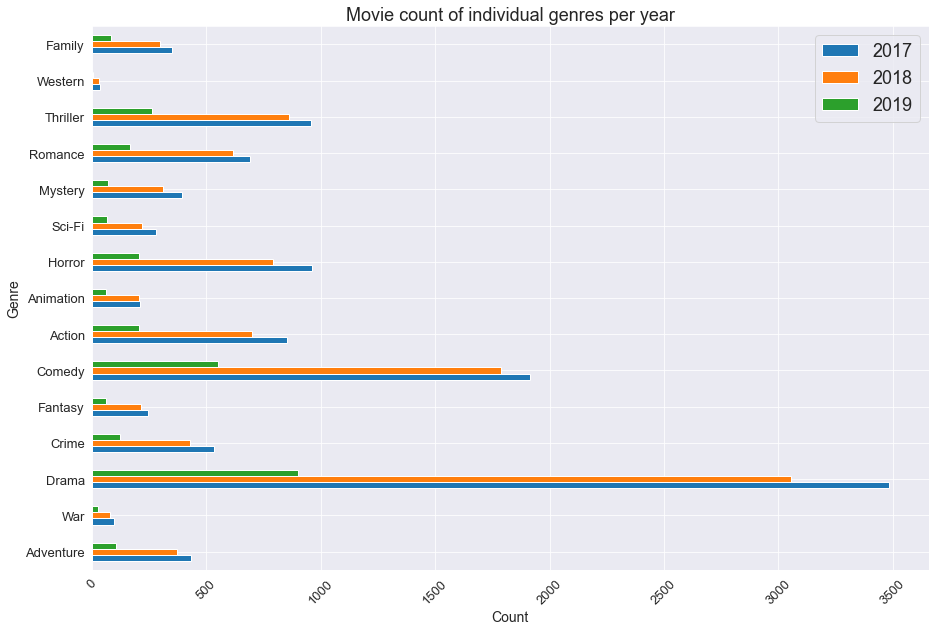

In [55]:
df_imdb_genres_count_T.iloc[:, 7:].plot(kind='barh',figsize = (15,10),fontsize=13)
plt.title("Movie count of individual genres per year", fontsize = 18)
plt.ylabel("Genre", fontsize = 14)
plt.xlabel("Count", fontsize = 14)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});

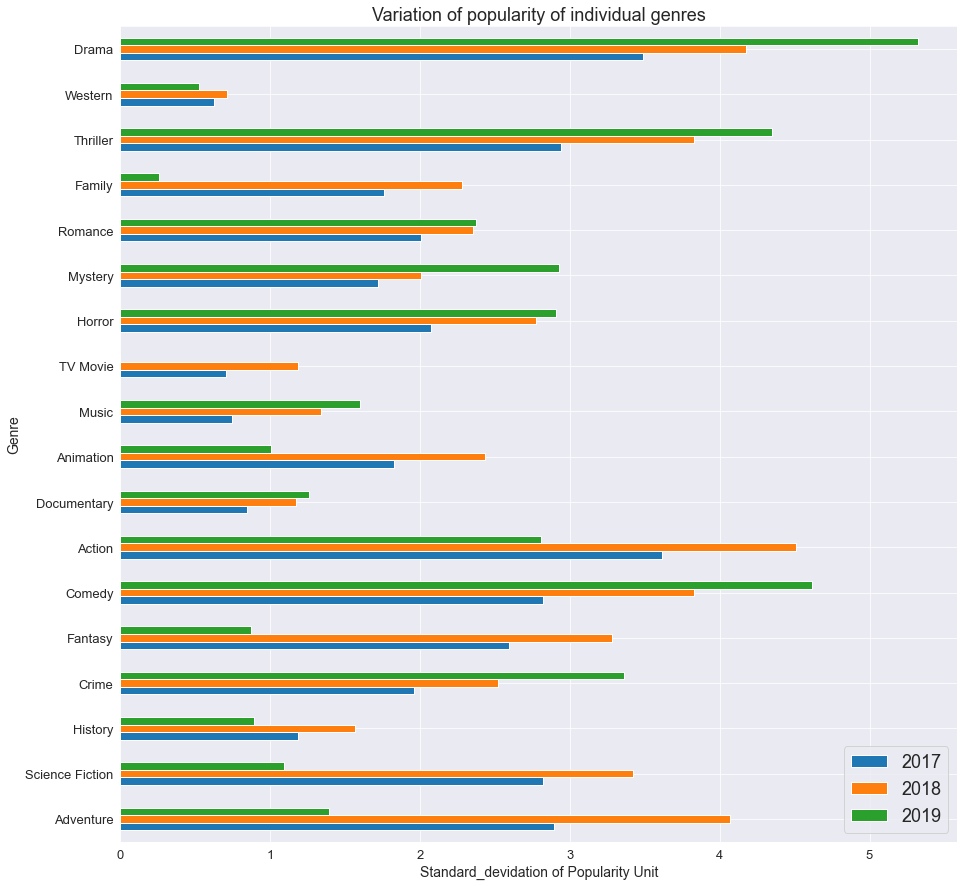

In [56]:
df_tmdb_popularity_std_T.iloc[:, 62:65].plot(kind='barh',figsize = (15,15),fontsize=13)
plt.title("Variation of popularity of individual genres", fontsize = 18)
plt.xlabel("Standard_devidation of Popularity Unit", fontsize = 14)
plt.ylabel("Genre", fontsize = 14)
plt.legend(prop={'size':18});

### Load TN Budget Dataset

In [58]:
df_tn = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/tn.movie_budgets.csv.gz')

In [59]:
display(df_tn.info())
display(df_tn.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


None

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [60]:
# Simple function to convert some currency values into numeric values

def conv_numeric(x):
    '''
    Convert string object to numeric type by removing '$' and delimiters
    Leave the numeric value as it is. 
    '''
    if isinstance(x, str):
        return float(x.replace(',', '').replace('$', ''))
    return float(x)

# Note: float function at the begining as it is applying on individual string

In [61]:
df_tn['production_budget'] = df_tn['production_budget'].apply(conv_numeric)
df_tn['domestic_gross'] = df_tn['domestic_gross'].apply(conv_numeric)
df_tn['worldwide_gross'] = df_tn['worldwide_gross'].apply(conv_numeric)

In [62]:
# Drop rows missing budget information 
df_tn = df_tn.dropna(axis = 0,
                     subset = ['production_budget', 'domestic_gross', 'worldwide_gross'])

# drop rows with missing domestic gross
df_tn = df_tn[(df_tn['domestic_gross']) != 0]

# we will extract 'year' and save it in a column
# later we will use this in conjunction with movie title to merge with imdb dataset

df_tn['release_date'] = pd.to_datetime(df_tn['release_date'])
df_tn['year'] = pd.DatetimeIndex(df_tn['release_date']).year
df_tn['title'] = df_tn['movie']

df_tn.drop(columns=['movie'], inplace=True)
df_tn.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,year,title
0,1,2009-12-18,425000000.0,760507625.0,2.776345e+09,2009,Avatar
1,2,2011-05-20,410600000.0,241063875.0,1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides
2,3,2019-06-07,350000000.0,42762350.0,1.497624e+08,2019,Dark Phoenix
3,4,2015-05-01,330600000.0,459005868.0,1.403014e+09,2015,Avengers: Age of Ultron
4,5,2017-12-15,317000000.0,620181382.0,1.316722e+09,2017,Star Wars Ep. VIII: The Last Jedi


In [63]:
# Perform some arithmatic 
df_tn['foreign_gross'] = df_tn['worldwide_gross'] - df_tn['domestic_gross']
df_tn['worldwide_profit'] = df_tn['worldwide_gross'] - df_tn['production_budget']
df_tn['domestic_profit'] = df_tn['domestic_gross'] - df_tn['production_budget']

# Calculate production to revenue ratio
df_tn['domestic_cost_profit_ratio'] = df_tn['production_budget'] / df_tn['domestic_profit'] 
df_tn['worldwide_cost_profit_ratio'] = df_tn['production_budget'] / df_tn['worldwide_profit'] 

# Normalization
df_tn['domestic_gross_n'] = df_tn['domestic_gross'].apply(
                            lambda x: (x - df_tn['domestic_gross'].mean())/df_tn['domestic_gross'].std())

df_tn['worldwide_gross_n'] = df_tn['worldwide_gross'].apply(
                            lambda x: (x - df_tn['worldwide_gross'].mean())/df_tn['worldwide_gross'].std())


df_tn.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,year,title,foreign_gross,worldwide_profit,domestic_profit,domestic_cost_profit_ratio,worldwide_cost_profit_ratio,domestic_gross_n,worldwide_gross_n
0,1,2009-12-18,425000000.0,760507625.0,2.776345e+09,2009,Avatar,2.015838e+09,2.351345e+09,335507625.0,1.266737,0.180748,10.160535,14.772221
1,2,2011-05-20,410600000.0,241063875.0,1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides,8.046000e+08,6.350639e+08,-169536125.0,-2.421903,0.646549,2.771210,5.216920
2,3,2019-06-07,350000000.0,42762350.0,1.497624e+08,2019,Dark Phoenix,1.070000e+08,-2.002376e+08,-307237650.0,-1.139183,-1.747923,-0.049720,0.270540
3,4,2015-05-01,330600000.0,459005868.0,1.403014e+09,2015,Avengers: Age of Ultron,9.440081e+08,1.072414e+09,128405868.0,2.574649,0.308276,5.871535,7.189893
4,5,2017-12-15,317000000.0,620181382.0,1.316722e+09,2017,Star Wars Ep. VIII: The Last Jedi,6.965404e+08,9.997217e+08,303181382.0,1.045579,0.317088,8.164330,6.713463


### Top 10 most expensive movies

C:\Users\smnge\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\smnge\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\smnge\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\smnge\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)


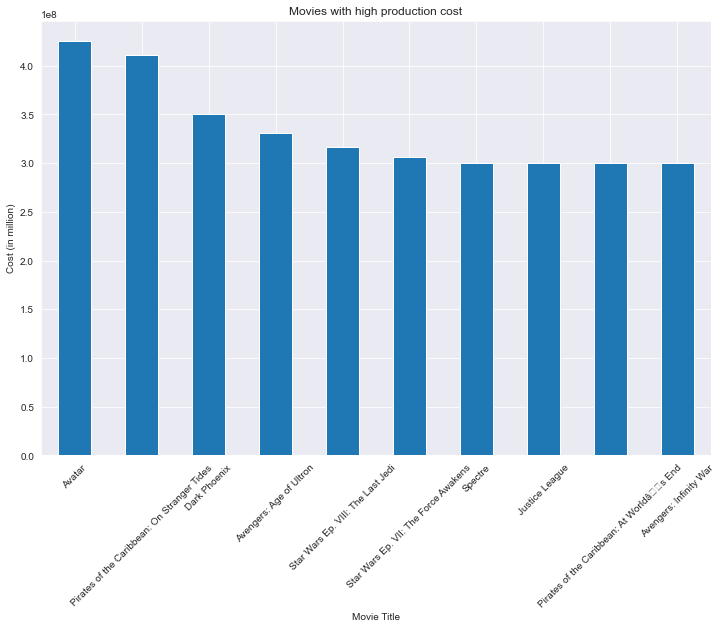

In [64]:
df_tn.groupby('title')['production_budget'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Movie Title')
plt.ylabel('Cost (in million)')
plt.xticks(rotation= 45)
plt.title('Movies with high production cost');

### Top 10 movies with highest domestic profit

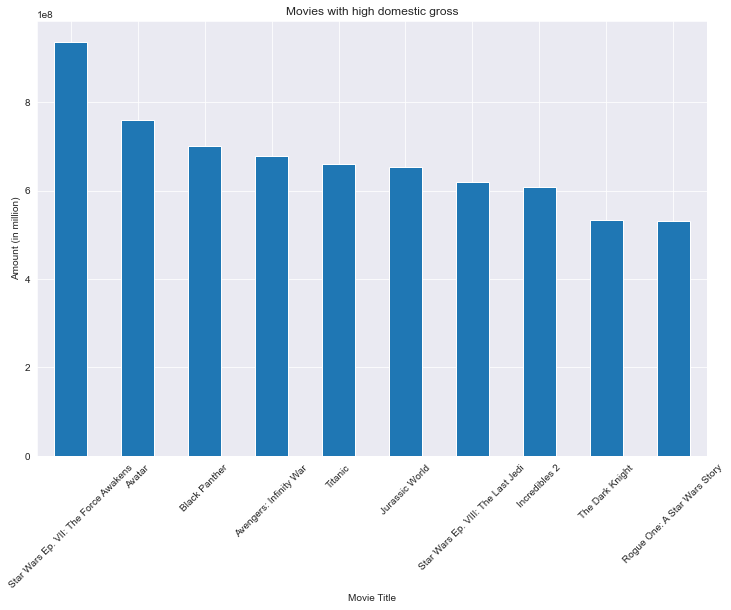

In [65]:
df_tn.groupby('title')['domestic_gross'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Movie Title')
plt.ylabel('Amount (in million)')
plt.xticks(rotation= 45)
plt.title('Movies with high domestic gross');

### Top 10 moves with the highest cost profit ratio

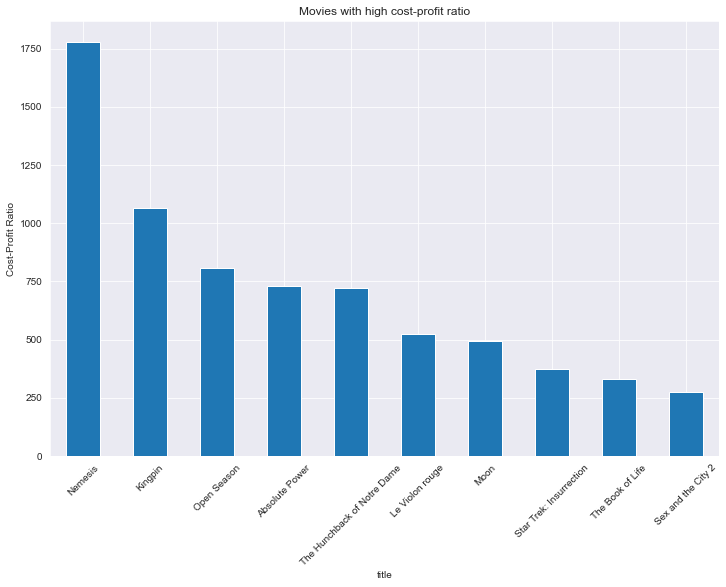

In [53]:
df_tn.groupby('title')['domestic_cost_profit_ratio'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
# plt.xlabel('Movie Title')
plt.ylabel('Cost-Profit Ratio')
plt.xticks(rotation= 45)
plt.title('Movies with high cost-profit ratio');

####  Lets remove some low budget movies from the equation


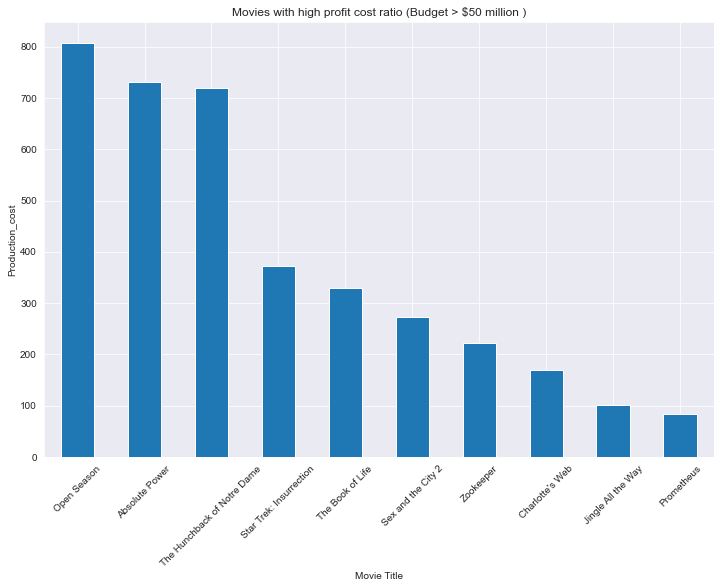

In [66]:
df_tn_hi_budget = df_tn[(df_tn['production_budget'] >= 50000000)]

df_tn_hi_budget.groupby('title')['domestic_cost_profit_ratio'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Movie Title')
plt.ylabel('Production_cost')
plt.xticks(rotation= 45)
plt.title('Movies with high profit cost ratio (Budget > $50 million )');

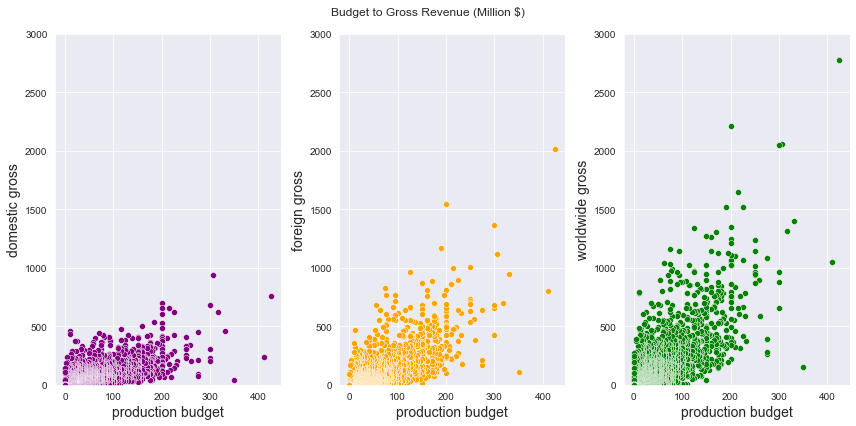

In [67]:
# Compare Gross Revenues
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (12,6))
fig.set_tight_layout(True)
sns.scatterplot(x=df_tn['production_budget']/1000000, y=df_tn['domestic_gross']/1000000, color='purple', ax=axes[0])
sns.scatterplot(x=df_tn['production_budget']/1000000, y=df_tn['worldwide_gross']/1000000, color='green', ax=axes[2])
sns.scatterplot(x=df_tn['production_budget']/1000000, y=df_tn['foreign_gross']/1000000, color='orange', ax=axes[1])

fig.suptitle("Budget to Gross Revenue (Million $)")
axes[0].set_ylabel("domestic gross", fontsize=14)
axes[1].set_ylabel("foreign gross", fontsize=14)
axes[2].set_ylabel("worldwide gross", fontsize=14)

axes[0].set_xlabel("production budget", fontsize=14)
axes[1].set_xlabel("production budget", fontsize=14)
axes[2].set_xlabel("production budget", fontsize=14)

axes[0].set_ylim([0,3000])
axes[1].set_ylim([0,3000])
axes[2].set_ylim([0,3000])

plt.show()

Strong correlation of budget with worldwide gross!

### Load BOM Datasets

In [68]:
df_bom = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/bom.movie_gross.csv.gz')

In [69]:
df_bom.info()
display(df_bom.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010


The gross revenue data are already in the TN Budget dataset, we will simply merge BOM to the TN dataset and keep the studio information only


### Load Rotten Tomatoes Dataset

In [70]:
# Read .tsv files
df_rt_movies = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/rt.movie_info.tsv.gz', delimiter = '\t')

# following data is in different latin1  codec latin
df_rt_reviews = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/rt.reviews.tsv.gz', delimiter = '\t', encoding='latin1')

In [71]:
display(df_rt_movies.head(3))

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN


In [72]:
df_rt_movies.isna().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

In [73]:
df_rt_reviews.head(3)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"


In [74]:
df_rt_reviews.isna().sum()

id                0
review         5563
rating        13517
fresh             0
critic         2722
top_critic        0
publisher       309
date              0
dtype: int64

Rotten Tomatoes dataset has lot of missing data and lacks suitable key to merge with other dataframe. For this study, we will ignore the Rotten Tomatoes datasets.

## Combine datasets from different source into a single dataframe

In [75]:
# We will try clean up as much possible the movie title for better match

def string_clean(x):
    '''
    Simple string manipulation to replace,remove inconsistencies in naming
    '''
    x = x.lower()
    x = x.replace('&', 'and')
    x = x.replace('#', '')
    x = x.replace('$', '')
    x = x.replace('*', '')
    x = x.replace('-', '')
    x = x.replace(',', '')
    x = x.replace('_', '')
    x = x.replace(':', '')
    x = x.replace(';', '')
    x = x.replace('[', '')
    x = x.replace(']', '')
    x = x.replace('(', '')
    x = x.replace(')', '')
    x = x.replace('+', '')
    x = x.replace('.', '')
    x = x.replace('/', '')
    x = x.strip()
    return x

In [76]:
df_tn['title_edit'] = df_tn['title'].apply(string_clean)
df_bom['title_edit'] = df_bom['title'].apply(string_clean)
df_imdb_merge['title_edit'] = df_imdb_merge['title'].apply(string_clean)
df_tmdb['title_edit'] = df_tmdb['title'].apply(string_clean)

In [77]:
# Merge dataset
df_merge1 = pd.merge(df_tn, df_imdb_merge, on= ['title_edit', 'year'])
df_merge2 = pd.merge(df_merge1, df_bom, on= ['title_edit', 'year'])
df_merge3 = pd.merge(df_merge2, df_tmdb, on= ['title_edit', 'year'])
df_merge = df_merge3.copy(deep=True)

print('No. of observations for TN budget dataset:', df_tn.shape[0])
print('No. of observations for IMDB dataset:', df_imdb_merge.shape[0])
print('No. of observations for BOM dataset:', df_bom.shape[0])
print('No. of observations for TMDB dataset:', df_tmdb.shape[0])

print('No. of observation after merge IMDB :', df_merge1.shape[0])
print('No. of observation after merge BOM :', df_merge2.shape[0])
print('No. of observation after merge TMDB :', df_merge3.shape[0])

df_merge.head()

No. of observations for TN budget dataset: 5234
No. of observations for IMDB dataset: 73856
No. of observations for BOM dataset: 3387
No. of observations for TMDB dataset: 26517
No. of observation after merge IMDB : 1389
No. of observation after merge BOM : 1109
No. of observation after merge TMDB : 1202


,id,release_date_x,production_budget,domestic_gross_x,worldwide_gross,year,title_x,foreign_gross_x,worldwide_profit,domestic_profit,...,title_x,studio,domestic_gross_y,foreign_gross_y,popularity,release_date_y,title_y,vote_average,vote_count,genre_y
0,2,2011-05-20,410600000.0,241063875.0,1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides,8.046000e+08,6.350639e+08,-169536125.0,...,Pirates of the Caribbean: On Stranger Tides,BV,241100000.0,804600000,30.579,2011-05-20,Pirates of the Caribbean: On Stranger Tides,6.4,8571,"Adventure,Action,Fantasy"
1,4,2015-05-01,330600000.0,459005868.0,1.403014e+09,2015,Avengers: Age of Ultron,9.440081e+08,1.072414e+09,128405868.0,...,Avengers: Age of Ultron,BV,459000000.0,946400000,44.383,2015-05-01,Avengers: Age of Ultron,7.3,13457,"Action,Adventure,Science Fiction"
2,7,2018-04-27,300000000.0,678815482.0,2.048134e+09,2018,Avengers: Infinity War,1.369319e+09,1.748134e+09,378815482.0,...,Avengers: Infinity War,BV,678800000.0,"1,369.5",80.773,2018-04-27,Avengers: Infinity War,8.3,13948,"Adventure,Action,Fantasy"
3,9,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,Justice League,4.269209e+08,3.559452e+08,-70975705.0,...,Justice League,WB,229000000.0,428900000,34.953,2017-11-17,Justice League,6.2,7510,"Action,Adventure,Fantasy,Science Fiction"
4,9,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,Justice League,4.269209e+08,3.559452e+08,-70975705.0,...,Justice League,WB,229000000.0,428900000,34.953,2017-11-17,Justice League,6.2,7510,"Action,Adventure,Fantasy,Science Fiction"


In [79]:
df_merge.columns

Index(['id', 'release_date_x', 'production_budget', 'domestic_gross_x',
       'worldwide_gross', 'year', 'title_x', 'foreign_gross_x',
       'worldwide_profit', 'domestic_profit', 'domestic_cost_profit_ratio',
       'worldwide_cost_profit_ratio', 'domestic_gross_n', 'worldwide_gross_n',
       'title_edit', 'runtime_minutes', 'averagerating', 'numvotes', 'title_y',
       'genre_x', 'title_x', 'studio', 'domestic_gross_y', 'foreign_gross_y',
       'popularity', 'release_date_y', 'title_y', 'vote_average', 'vote_count',
       'genre_y'],
      dtype='object')

In [83]:
df_merge.rename(columns = 
                {"release_date_x": "release_date",
                 "domestic_gross_x":"domestric_gross",
                 "foreign_gross_x": "foreign_gross",
                 "genre_x": "genre"},
                
                inplace = True)

In [89]:
df_merge.columns

Index(['id', 'release_date', 'production_budget', 'domestric_gross',
       'worldwide_gross', 'year', 'title_x', 'foreign_gross',
       'worldwide_profit', 'domestic_profit', 'domestic_cost_profit_ratio',
       'worldwide_cost_profit_ratio', 'domestic_gross_n', 'worldwide_gross_n',
       'title_edit', 'runtime_minutes', 'averagerating', 'numvotes', 'title_y',
       'genre', 'title_x', 'studio', 'domestic_gross_y', 'foreign_gross_y',
       'popularity', 'release_date_y', 'title_y', 'vote_average', 'vote_count',
       'genre_y'],
      dtype='object')

In [91]:
final_columns_to_drop = ['id', 'title_x', 'title_y', 'domestic_gross_y', 'foreign_gross_y',
                         'release_date_y', 'title_y', 'genre_y']
df_merge.drop(columns = final_columns_to_drop, inplace=True)

In [92]:
df_merge.head()

,release_date,production_budget,domestric_gross,worldwide_gross,year,foreign_gross,worldwide_profit,domestic_profit,domestic_cost_profit_ratio,worldwide_cost_profit_ratio,...,worldwide_gross_n,title_edit,runtime_minutes,averagerating,numvotes,genre,studio,popularity,vote_average,vote_count
0,2011-05-20,410600000.0,241063875.0,1.045664e+09,2011,8.046000e+08,6.350639e+08,-169536125.0,-2.421903,0.646549,...,5.216920,pirates of the caribbean on stranger tides,136.0,6.6,447624,"Action,Adventure,Fantasy",BV,30.579,6.4,8571
1,2015-05-01,330600000.0,459005868.0,1.403014e+09,2015,9.440081e+08,1.072414e+09,128405868.0,2.574649,0.308276,...,7.189893,avengers age of ultron,141.0,7.3,665594,"Action,Adventure,Sci-Fi",BV,44.383,7.3,13457
2,2018-04-27,300000000.0,678815482.0,2.048134e+09,2018,1.369319e+09,1.748134e+09,378815482.0,0.791942,0.171612,...,10.751680,avengers infinity war,149.0,8.5,670926,"Action,Adventure,Sci-Fi",BV,80.773,8.3,13948
3,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,4.269209e+08,3.559452e+08,-70975705.0,-4.226798,0.842826,...,3.065236,justice league,120.0,6.5,329135,"Action,Adventure,Fantasy",WB,34.953,6.2,7510
4,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,4.269209e+08,3.559452e+08,-70975705.0,-4.226798,0.842826,...,3.065236,justice league,120.0,6.5,329135,"Action,Adventure,Fantasy",WB,34.953,6.2,7510
